In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

In [14]:
train_targets = pd.read_parquet('./data/A/train_targets.parquet')
X_test_estimated = pd.read_parquet('./data/A/X_test_estimated.parquet')
X_train_estimated = pd.read_parquet('./data/A/X_train_estimated.parquet')
X_train_observed = pd.read_parquet('./data/A/X_train_observed.parquet')

In [497]:
df = pd.concat([X_train_observed, X_train_estimated])
df = pd.merge(df, train_targets, left_on='date_forecast', right_on='time', how='inner')
df = df.drop(columns=['date_calc', 'date_forecast'])
df = df.drop(columns=['elevation:m', 'snow_density:kgm3', 'snow_drift:idx'], axis=1)

imputer = SimpleImputer(strategy='mean')
df[['ceiling_height_agl:m', 'cloud_base_agl:m']] = imputer.fit_transform(df[['ceiling_height_agl:m', 'cloud_base_agl:m']])

X = df.drop(columns=['pv_measurement', 'time']) # Drop the index, target, and time columns
y = df['pv_measurement'] # Target variable

In [498]:
# Define the split date
split_date = '2022-10-27'

# Convert the 'time' column to a datetime object
df['time'] = pd.to_datetime(df['time'])

# Sorting the data by the 'time' column to maintain chronological order
df.sort_values('time', inplace=True)

# Splitting the data into training and test sets based on the split date
train_df = df[df['time'] < split_date]
test_df = df[df['time'] >= split_date]

# Identifying the features and the target variable
X_train = train_df.drop(columns=['pv_measurement', 'time'])  # Assuming all other columns are features
y_train = train_df['pv_measurement']
X_test = test_df.drop(columns=['pv_measurement', 'time'])
y_test = test_df['pv_measurement']

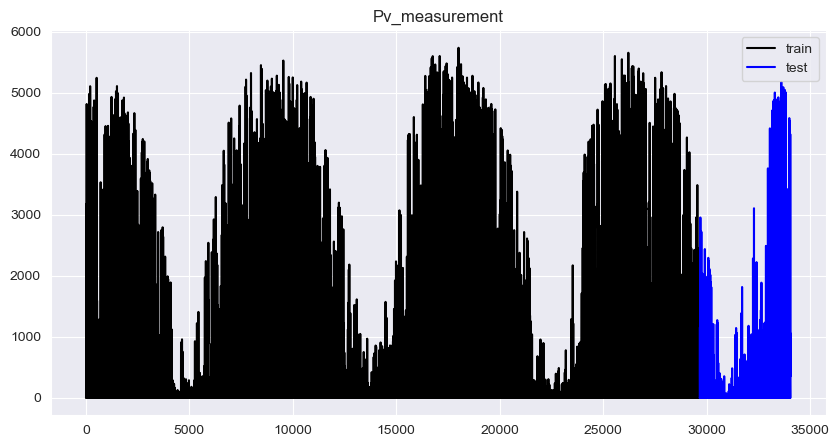

In [499]:
y_train.plot(style='k', figsize=(10, 5), label='train')
y_test.plot(style='b', figsize=(10, 5), label='test')

plt.title('Pv_measurement')
plt.legend()

# First Baseline Model: XGBoost

In [500]:
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)
y_pred = np.maximum(y_pred, 0)
# Calculate MAE on the test set
mae = mean_absolute_error(y_test, y_pred)
mae

131.37095773036935

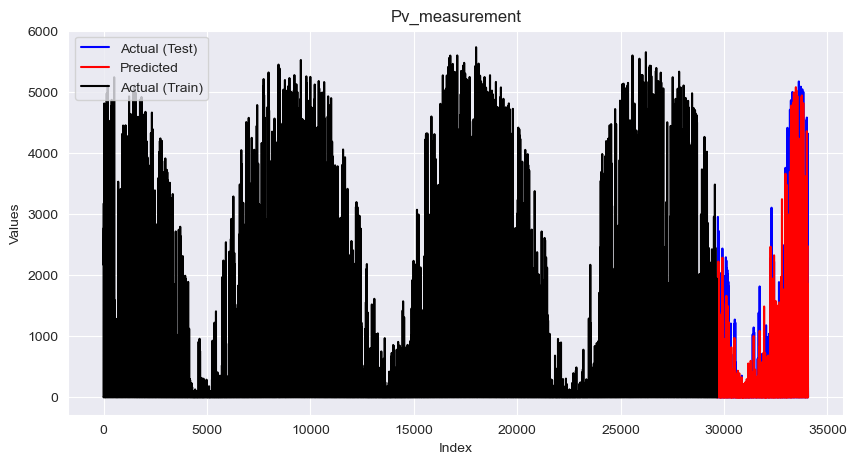

In [501]:
# Create a DataFrame to hold actual and predicted values
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Plot actual and predicted values
plt.figure(figsize=(10, 5))
plt.plot(results_df.index, results_df['Actual'], 'b', label='Actual (Test)')
plt.plot(results_df.index, results_df['Predicted'], 'r', label='Predicted')
plt.plot(y_train.index, y_train, 'k', label='Actual (Train)')
plt.title('Pv_measurement')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.show()

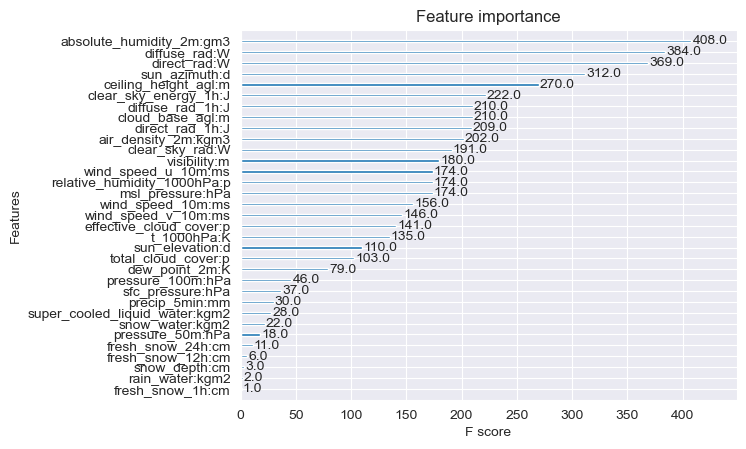

In [502]:
xgb.plot_importance(xgb_model)
plt.show()

In [503]:
def date_features(df):
    df['hour'] = pd.to_datetime(df['time']).dt.hour
    df['day'] = pd.to_datetime(df['time']).dt.dayofyear
    df['month'] = pd.to_datetime(df['time']).dt.month
    df['quarter'] = pd.to_datetime(df['time']).dt.quarter

    df['lagged_absolute_humidity_2m_1'] = df['absolute_humidity_2m:gm3'].shift(1)
    df['lagged_absolute_humidity_2m_3'] = df['absolute_humidity_2m:gm3'].shift(3)
    df['lagged_absolute_humidity_2m_6'] = df['absolute_humidity_2m:gm3'].shift(6)
    df['rolling_mean_absolute_humidity_2m_3'] = df['absolute_humidity_2m:gm3'].rolling(window=3).mean()

    df['lagged_diffuse_rad_1'] = df['diffuse_rad:W'].shift(1)
    df['lagged_diffuse_rad_3'] = df['diffuse_rad:W'].shift(3)
    df['lagged_diffuse_rad_6'] = df['diffuse_rad:W'].shift(6)
    df['rolling_mean_diffuse_rad_3'] = df['diffuse_rad:W'].rolling(window=3).mean()
    
    df['lagged_direct_rad_1'] = df['direct_rad:W'].shift(1)
    df['lagged_direct_rad_3'] = df['direct_rad:W'].shift(3)
    df['lagged_direct_rad_6'] = df['direct_rad:W'].shift(6)
    df['rolling_mean_direct_rad_3'] = df['direct_rad:W'].rolling(window=3).mean()
    
    df['lagged_sun_azimuth_1'] = df['sun_azimuth:d'].shift(1)
    df['lagged_sun_azimuth_3'] = df['sun_azimuth:d'].shift(3)
    df['lagged_sun_azimuth_6'] = df['sun_azimuth:d'].shift(6)
    df['rolling_mean_sun_azimuth_3'] = df['sun_azimuth:d'].rolling(window=3).mean()
    return df

df = date_features(df)

In [504]:
def is_estimated(df):
    split_date = '2022-10-27'
    df['is_estimated'] = 0  # Initialize with 0 (indicating observed)
    df.loc[df['time'] >= pd.Timestamp(split_date), 'is_estimated'] = 1  # Set 1 for estimated data
    return df

df = is_estimated(df)

In [505]:
# Define the split date
split_date = '2022-10-27'

# Convert the 'time' column to a datetime object
df['time'] = pd.to_datetime(df['time'])

# Sorting the data by the 'time' column to maintain chronological order
df.sort_values('time', inplace=True)

# Splitting the data into training and test sets based on the split date
train_df = df[df['time'] < split_date]
test_df = df[df['time'] >= split_date]

# Identifying the features and the target variable
X_train = train_df.drop(columns=['pv_measurement', 'time'])  # Assuming all other columns are features
y_train = train_df['pv_measurement']
X_test = test_df.drop(columns=['pv_measurement', 'time'])
y_test = test_df['pv_measurement']

In [506]:
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)
y_pred = np.maximum(y_pred, 0)
# Calculate MAE on the test set
mae = mean_absolute_error(y_test, y_pred)
mae

133.44024069515396

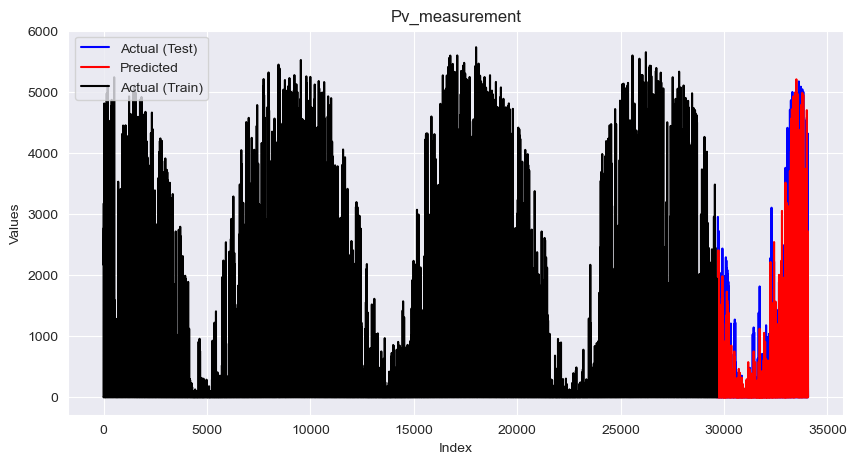

In [507]:
# Create a DataFrame to hold actual and predicted values
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Plot actual and predicted values
plt.figure(figsize=(10, 5))
plt.plot(results_df.index, results_df['Actual'], 'b', label='Actual (Test)')
plt.plot(results_df.index, results_df['Predicted'], 'r', label='Predicted')
plt.plot(y_train.index, y_train, 'k', label='Actual (Train)')
plt.title('Pv_measurement')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.show()

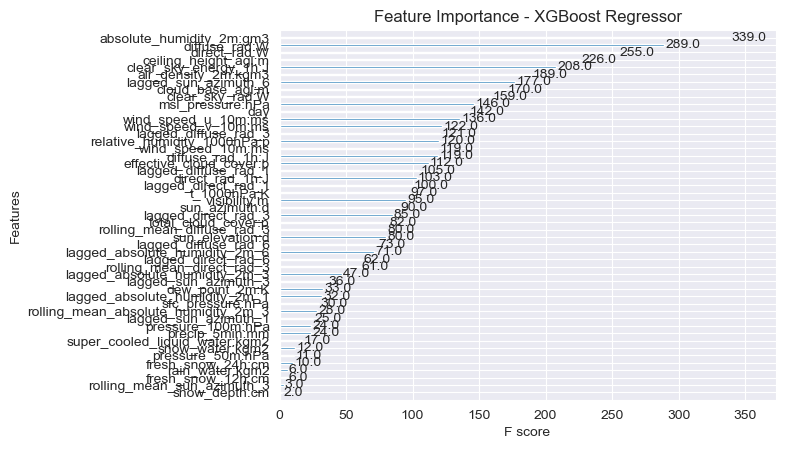

In [508]:
xgb.plot_importance(xgb_model, importance_type='weight')  # You can adjust 'max_num_features' as needed
plt.title("Feature Importance - XGBoost Regressor")
plt.show()